# Churn Prediction

Since we know our best customers by segmentation and lifetime value prediction, we should also work hard on retaining them. That’s what makes Retention Rate is one of the most critical metrics.

Retention Rate is an indication of how good is your product market fit (PMF). If your PMF is not satisfactory, you should see your customers churning very soon. One of the powerful tools to improve Retention Rate (hence the PMF) is Churn Prediction. By using this technique, you can easily find out who is likely to churn in the given period. In this article, we will use a **Telco dataset** (https://www.kaggle.com/blastchar/telco-customer-churn) and go over the following steps to develop a Churn Prediction model:

* Exploratory data analysis
* Feature engineering
* Investigating how the features affect Retention by using Logistic Regression
* Building a classification model with XGBoost

In [1]:
from datetime import datetime, timedelta,date
import pandas as pd
%matplotlib inline
from sklearn.metrics import classification_report,confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from __future__ import division
from sklearn.cluster import KMeans

import warnings
warnings.filterwarnings("ignore")

In [2]:
import plotly as py
import plotly.offline as pyoff
import plotly.graph_objs as go

In [3]:
import xgboost as xgb
from sklearn.model_selection import KFold, cross_val_score, train_test_split

In [4]:
pyoff.init_notebook_mode()

# Exploratory Data Analysis (EDA)

In [5]:
df_data = pd.read_csv('churn_data.csv')

In [6]:
df_data.head(10)

customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   
5  9305-CDSKC  Female              0      No         No       8          Yes   
6  1452-KIOVK    Male              0      No        Yes      22          Yes   
7  6713-OKOMC  Female              0      No         No      10           No   
8  7892-POOKP  Female              0     Yes         No      28          Yes   
9  6388-TABGU    Male              0      No        Yes      62          Yes   

      MultipleLines InternetService OnlineSecurity  ... DeviceProtection  \
0  No phone service             DSL             No  ...               No   
1                No             DSL            Yes  ...              Yes   
2                No             DSL            Yes  ...               No   
3  No phone service             DSL            Yes  ...              Yes   
4                No     Fiber optic             No  ...               No   
5               Yes     Fiber optic             No  ...              Yes   
6               Yes     Fiber optic             No  ...               No   
7  No phone service             DSL            Yes  ...               No   
8               Yes     Fiber optic             No  ...              Yes   
9                No             DSL            Yes  ...               No   

  TechSupport StreamingTV StreamingMovies        Contract PaperlessBilling  \
0          No          No              No  Month-to-month              Yes   
1          No          No              No        One year               No   
2          No          No              No  Month-to-month              Yes   
3         Yes          No              No        One year               No   
4          No          No              No  Month-to-month              Yes   
5          No         Yes             Yes  Month-to-month              Yes   
6          No         Yes              No  Month-to-month              Yes   
7          No          No              No  Month-to-month               No   
8         Yes         Yes             Yes  Month-to-month              Yes   
9          No          No              No        One year               No   

               PaymentMethod MonthlyCharges  TotalCharges Churn  
0           Electronic check          29.85         29.85    No  
1               Mailed check          56.95        1889.5    No  
2               Mailed check          53.85        108.15   Yes  
3  Bank transfer (automatic)          42.30       1840.75    No  
4           Electronic check          70.70        151.65   Yes  
5           Electronic check          99.65         820.5   Yes  
6    Credit card (automatic)          89.10        1949.4    No  
7               Mailed check          29.75         301.9    No  
8           Electronic check         104.80       3046.05   Yes  
9  Bank transfer (automatic)          56.15       3487.95    No  

[10 rows x 21 columns]

In [7]:
df_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


Data fall under two categories:
* Categorical features: gender, streaming tv, payment method &, etc.
* Numerical features: tenure, monthly charges, total charges

# Feature Engineering
1. Group the numerical columns by using clustering techniques
2. Apply Label Encoder to categorical features which are binary
3. Apply get_dummies() to categorical features which have multiple values

# Categorical features

In [8]:
# Convert Churn column to integer
df_data.loc[df_data.Churn=='No','Churn'] = 0 
df_data.loc[df_data.Churn=='Yes','Churn'] = 1

In [9]:
df_data["Churn"] = df_data.Churn.astype(float)
df_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [10]:
df_data.groupby('gender').Churn.mean()

gender
Female    0.269209
Male      0.261603
Name: Churn, dtype: float64

Female customers are more likely to churn vs. male customers, but the difference is minimal (~0.8%).

In [11]:
df_plot = df_data.groupby('gender').Churn.mean().reset_index()
plot_data = [
    go.Bar(
        x=df_plot['gender'],
        y=df_plot['Churn'],
        width = [0.5, 0.5],
        marker=dict(
        color=['green', 'blue'])
    )
]

plot_layout = go.Layout(
        xaxis={"type": "category"},
        yaxis={"title": "Churn Rate"},
        title='Gender',
        plot_bgcolor  = 'rgb(243,243,243)',
        paper_bgcolor  = 'rgb(243,243,243)',
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

In [12]:
df_plot = df_data.groupby('Partner').Churn.mean().reset_index()
plot_data = [
    go.Bar(
        x=df_plot['Partner'],
        y=df_plot['Churn'],
        width = [0.5, 0.5],
        marker=dict(
        color=['green', 'blue'])
    )
]

plot_layout = go.Layout(
        xaxis={"type": "category"},
        yaxis={"title": "Churn Rate"},
        title='Partner',
        plot_bgcolor  = 'rgb(243,243,243)',
        paper_bgcolor  = 'rgb(243,243,243)',
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

In [13]:
df_plot = df_data.groupby('PhoneService').Churn.mean().reset_index()
plot_data = [
    go.Bar(
        x=df_plot['PhoneService'],
        y=df_plot['Churn'],
        width = [0.5, 0.5],
        marker=dict(
        color=['green', 'blue'])
    )
]

plot_layout = go.Layout(
        xaxis={"type": "category"},
        yaxis={"title": "Churn Rate"},
        title='Phone Service',
        plot_bgcolor  = 'rgb(243,243,243)',
        paper_bgcolor  = 'rgb(243,243,243)',
        
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

In [14]:
df_plot = df_data.groupby('MultipleLines').Churn.mean().reset_index()
plot_data = [
    go.Bar(
        x=df_plot['MultipleLines'],
        y=df_plot['Churn'],
        width = [0.5, 0.5, 0.5],
        marker=dict(
        color=['green', 'blue', 'orange'])
    )
]

plot_layout = go.Layout(
        xaxis={"type": "category"},
        title='Multiple Lines',
        yaxis={"title": "Churn Rate"},
        plot_bgcolor  = 'rgb(243,243,243)',
        paper_bgcolor  = 'rgb(243,243,243)',
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

In [15]:
df_plot = df_data.groupby('InternetService').Churn.mean().reset_index()
plot_data = [
    go.Bar(
        x=df_plot['InternetService'],
        y=df_plot['Churn'],
        width = [0.5, 0.5, 0.5],
        marker=dict(
        color=['green', 'blue', 'orange'])
    )
]

plot_layout = go.Layout(
        xaxis={"type": "category"},
        title='Internet Service',
        yaxis={"title": "Churn Rate"},
        plot_bgcolor  = 'rgb(243,243,243)',
        paper_bgcolor  = 'rgb(243,243,243)',
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

This chart reveals customers who have Fiber optic as Internet Service are more likely to churn. I normally expect Fiber optic customers to churn less due to they use a more premium service. But this can happen due to high prices, competition, customer service, and many other reasons.

In [16]:
df_plot = df_data.groupby('OnlineSecurity').Churn.mean().reset_index()
plot_data = [
    go.Bar(
        x=df_plot['OnlineSecurity'],
        y=df_plot['Churn'],
        width = [0.5, 0.5, 0.5],
        marker=dict(
        color=['green', 'blue', 'orange'])
    )
]

plot_layout = go.Layout(
        xaxis={"type": "category"},
        yaxis={"title": "Churn Rate"},
        title='Online Security',
        plot_bgcolor  = "rgb(243,243,243)",
        paper_bgcolor  = "rgb(243,243,243)",
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

In [17]:
df_plot = df_data.groupby('OnlineBackup').Churn.mean().reset_index()
plot_data = [
    go.Bar(
        x=df_plot['OnlineBackup'],
        y=df_plot['Churn'],
        width = [0.5, 0.5, 0.5],
        marker=dict(
        color=['green', 'blue', 'orange'])
    )
]

plot_layout = go.Layout(
        xaxis={"type": "category"},
        title='Online Backup',
        plot_bgcolor  = "rgb(243,243,243)",
        paper_bgcolor  = "rgb(243,243,243)",
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

In [18]:
df_plot = df_data.groupby('DeviceProtection').Churn.mean().reset_index()
plot_data = [
    go.Bar(
        x=df_plot['DeviceProtection'],
        y=df_plot['Churn'],
        width = [0.5, 0.5, 0.5],
        marker=dict(
        color=['green', 'blue', 'orange'])
    )
]

plot_layout = go.Layout(
        xaxis={"type": "category"},
        title='Device Protection',
        plot_bgcolor  = "rgb(243,243,243)",
        paper_bgcolor  = "rgb(243,243,243)",
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

In [19]:
df_plot = df_data.groupby('TechSupport').Churn.mean().reset_index()
plot_data = [
    go.Bar(
        x=df_plot['TechSupport'],
        y=df_plot['Churn'],
        width = [0.5, 0.5, 0.5],
        marker=dict(
        color=['green', 'blue', 'orange'])
    )
]

plot_layout = go.Layout(
        xaxis={"type": "category"},
        title='Tech Support',
        plot_bgcolor  = "rgb(243,243,243)",
        paper_bgcolor  = "rgb(243,243,243)",
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

Customers don’t use Tech Support are more like to churn (~25% difference).

In [20]:
df_plot = df_data.groupby('StreamingTV').Churn.mean().reset_index()
plot_data = [
    go.Bar(
        x=df_plot['StreamingTV'],
        y=df_plot['Churn'],
        width = [0.5, 0.5, 0.5],
        marker=dict(
        color=['green', 'blue', 'orange'])
    )
]

plot_layout = go.Layout(
        xaxis={"type": "category"},
        title='Streaming TV',
        plot_bgcolor  = "rgb(243,243,243)",
        paper_bgcolor  = "rgb(243,243,243)",
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

In [21]:
df_plot = df_data.groupby('StreamingMovies').Churn.mean().reset_index()
plot_data = [
    go.Bar(
        x=df_plot['StreamingMovies'],
        y=df_plot['Churn'],
        width = [0.5, 0.5, 0.5],
        marker=dict(
        color=['green', 'blue', 'orange'])
    )
]

plot_layout = go.Layout(
        xaxis={"type": "category"},
        title='Streaming Movies',
        plot_bgcolor  = "rgb(243,243,243)",
        paper_bgcolor  = "rgb(243,243,243)",
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

In [22]:
df_plot = df_data.groupby('Contract').Churn.mean().reset_index()
plot_data = [
    go.Bar(
        x=df_plot['Contract'],
        y=df_plot['Churn'],
        width = [0.5, 0.5, 0.5],
        marker=dict(
        color=['green', 'blue', 'orange'])
    )
]

plot_layout = go.Layout(
        xaxis={"type": "category"},
        title='Contract',
        plot_bgcolor  = "rgb(243,243,243)",
        paper_bgcolor  = "rgb(243,243,243)",
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

As expected, the shorter contract means higher churn rate.

In [23]:
df_plot = df_data.groupby('PaperlessBilling').Churn.mean().reset_index()
plot_data = [
    go.Bar(
        x=df_plot['PaperlessBilling'],
        y=df_plot['Churn'],
        width = [0.5, 0.5, 0.5],
        marker=dict(
        color=['green', 'blue', 'orange'])
    )
]

plot_layout = go.Layout(
        xaxis={"type": "category"},
        title='Paperless Billing',
        plot_bgcolor  = "rgb(243,243,243)",
        paper_bgcolor  = "rgb(243,243,243)",
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

In [24]:
df_plot = df_data.groupby('PaymentMethod').Churn.mean().reset_index()
plot_data = [
    go.Bar(
        x=df_plot['PaymentMethod'],
        y=df_plot['Churn'],
        width = [0.5, 0.5, 0.5,0.5],
        marker=dict(
        color=['green', 'blue', 'orange','red'])
    )
]

plot_layout = go.Layout(
        xaxis={"type": "category"},
        title='Payment Method',
        plot_bgcolor  = "rgb(243,243,243)",
        paper_bgcolor  = "rgb(243,243,243)",
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

Automating the payment makes the customer more likely to retain in your platform (~30% difference).

# Numerical features

## Feature Engineering for Numerical columns

1. Using Elbow Method to identify the appropriate number of clusters
2. Applying K-means logic to the selected column and change the naming
3. Observe the profile of clusters

In [25]:
df_data.tenure.describe()

count    7043.000000
mean       32.371149
std        24.559481
min         0.000000
25%         9.000000
50%        29.000000
75%        55.000000
max        72.000000
Name: tenure, dtype: float64

In [26]:
df_plot = df_data.groupby('tenure').Churn.mean().reset_index()


plot_data = [
    go.Scatter(
        x=df_plot['tenure'],
        y=df_plot['Churn'],
        mode='markers',
        name='Low',
        marker= dict(size= 7,
            line= dict(width=1),
            color= 'blue',
            opacity= 0.8
           ),
    )
]

plot_layout = go.Layout(
        yaxis= {'title': "Churn Rate"},
        xaxis= {'title': "Tenure"},
        title='Tenure based Churn rate',
        plot_bgcolor  = "rgb(243,243,243)",
        paper_bgcolor  = "rgb(243,243,243)",
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

Super apparent that the higher tenure means lower Churn Rate.

In [27]:
def order_cluster(cluster_field_name, target_field_name,df,ascending):
    new_cluster_field_name = 'new_' + cluster_field_name
    df_new = df.groupby(cluster_field_name)[target_field_name].mean().reset_index()
    df_new = df_new.sort_values(by=target_field_name,ascending=ascending).reset_index(drop=True)
    df_new['index'] = df_new.index
    df_final = pd.merge(df,df_new[[cluster_field_name,'index']], on=cluster_field_name)
    df_final = df_final.drop([cluster_field_name],axis=1)
    df_final = df_final.rename(columns={"index":cluster_field_name})
    return df_final

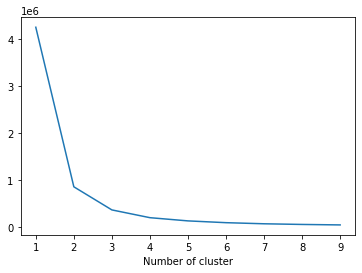

In [28]:
sse={}
df_cluster = df_data[['tenure']]
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(df_cluster)
    df_cluster["clusters"] = kmeans.labels_
    sse[k] = kmeans.inertia_ 
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.show()

In [29]:
kmeans = KMeans(n_clusters=3)
kmeans.fit(df_data[['tenure']])
df_data['TenureCluster'] = kmeans.predict(df_data[['tenure']])

In [30]:
df_data = order_cluster('TenureCluster', 'tenure',df_data,True)

In [31]:
df_data.groupby('TenureCluster').tenure.describe()

count       mean       std   min   25%   50%   75%   max
TenureCluster                                                           
0              2941.0   7.801428  6.227163   0.0   2.0   6.0  13.0  21.0
1              1929.0  34.792120  8.297679  22.0  27.0  35.0  42.0  49.0
2              2173.0  63.475380  7.172433  50.0  57.0  65.0  70.0  72.0

In [32]:
df_data['TenureCluster'] = df_data["TenureCluster"].replace({0:'Low',1:'Mid',2:'High'})

In [33]:
df_plot = df_data.groupby('TenureCluster').Churn.mean().reset_index()
plot_data = [
    go.Bar(
        x=df_plot['TenureCluster'],
        y=df_plot['Churn'],
        width = [0.5, 0.5, 0.5,0.5],
        marker=dict(
        color=['green', 'blue', 'orange','red'])
    )
]

plot_layout = go.Layout(
        xaxis={"type": "category","categoryarray":['Low','Mid','High']},
        title='Tenure Cluster vs Churn Rate',
        plot_bgcolor  = "rgb(243,243,243)",
        paper_bgcolor  = "rgb(243,243,243)",
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

In [34]:
df_plot = df_data.copy()
df_plot['MonthlyCharges'] = df_plot['MonthlyCharges'].astype(int)
df_plot = df_plot.groupby('MonthlyCharges').Churn.mean().reset_index()


plot_data = [
    go.Scatter(
        x=df_plot['MonthlyCharges'],
        y=df_plot['Churn'],
        mode='markers',
        name='Low',
        marker= dict(size= 7,
            line= dict(width=1),
            color= 'blue',
            opacity= 0.8
           ),
    )
]

plot_layout = go.Layout(
        yaxis= {'title': "Churn Rate"},
        xaxis= {'title': "Monthly Charges"},
        title='Monthly Charge vs Churn rate',
        plot_bgcolor  = "rgb(243,243,243)",
        paper_bgcolor  = "rgb(243,243,243)",
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

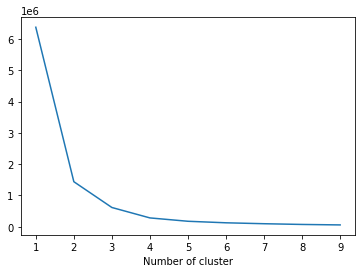

In [35]:
sse={}
df_cluster = df_data[['MonthlyCharges']]
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(df_cluster)
    df_cluster["clusters"] = kmeans.labels_
    sse[k] = kmeans.inertia_ 
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.show()

In [36]:
kmeans = KMeans(n_clusters=3)
kmeans.fit(df_data[['MonthlyCharges']])
df_data['MonthlyChargeCluster'] = kmeans.predict(df_data[['MonthlyCharges']])

In [37]:
df_data = order_cluster('MonthlyChargeCluster', 'MonthlyCharges',df_data,True)

In [38]:
df_data.groupby('MonthlyChargeCluster').MonthlyCharges.describe()

count       mean        std    min    25%     50%  \
MonthlyChargeCluster                                                       
0                     1892.0  23.384619   5.660437  18.25  19.80  20.400   
1                     2237.0  61.614350  10.434888  42.60  51.80  61.500   
2                     2914.0  94.043102  10.349153  77.80  85.05  93.875   

                         75%     max  
MonthlyChargeCluster                  
0                      25.05   42.40  
1                      70.65   77.75  
2                     101.90  118.75

In [39]:
df_data['MonthlyChargeCluster'] = df_data["MonthlyChargeCluster"].replace({0:'Low',1:'Mid',2:'High'})

In [40]:
df_plot = df_data.groupby('MonthlyChargeCluster').Churn.mean().reset_index()
plot_data = [
    go.Bar(
        x=df_plot['MonthlyChargeCluster'],
        y=df_plot['Churn'],
        width = [0.5, 0.5, 0.5],
        marker=dict(
        color=['green', 'blue', 'orange'])
    )
]

plot_layout = go.Layout(
        xaxis={"type": "category","categoryarray":['Low','Mid','High']},
        title='Monthly Charge Cluster vs Churn Rate',
        plot_bgcolor  = "rgb(243,243,243)",
        paper_bgcolor  = "rgb(243,243,243)",
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

In [41]:
df_data[pd.to_numeric(df_data['TotalCharges'], errors='coerce').isnull()]

customerID  gender  SeniorCitizen Partner Dependents  tenure  \
92    3115-CZMZD    Male              0      No        Yes       0   
138   4367-NUYAO    Male              0     Yes        Yes       0   
425   7644-OMVMY    Male              0     Yes        Yes       0   
488   3213-VVOLG    Male              0     Yes        Yes       0   
566   2520-SGTTA  Female              0     Yes        Yes       0   
681   2923-ARZLG    Male              0     Yes        Yes       0   
1977  4472-LVYGI  Female              0     Yes        Yes       0   
2116  1371-DWPAZ  Female              0     Yes        Yes       0   
3015  4075-WKNIU  Female              0     Yes        Yes       0   
3028  2775-SEFEE    Male              0      No        Yes       0   
4250  5709-LVOEQ  Female              0     Yes        Yes       0   

     PhoneService     MultipleLines InternetService       OnlineSecurity  ...  \
92            Yes                No              No  No internet service  ...   
138           Yes               Yes              No  No internet service  ...   
425           Yes                No              No  No internet service  ...   
488           Yes               Yes              No  No internet service  ...   
566           Yes                No              No  No internet service  ...   
681           Yes                No              No  No internet service  ...   
1977           No  No phone service             DSL                  Yes  ...   
2116           No  No phone service             DSL                  Yes  ...   
3015          Yes               Yes             DSL                   No  ...   
3028          Yes               Yes             DSL                  Yes  ...   
4250          Yes                No             DSL                  Yes  ...   

              StreamingTV      StreamingMovies  Contract PaperlessBilling  \
92    No internet service  No internet service  Two year               No   
138   No internet service  No internet service  Two year               No   
425   No internet service  No internet service  Two year               No   
488   No internet service  No internet service  Two year               No   
566   No internet service  No internet service  Two year               No   
681   No internet service  No internet service  One year              Yes   
1977                  Yes                   No  Two year              Yes   
2116                  Yes                   No  Two year               No   
3015                  Yes                   No  Two year               No   
3028                   No                   No  Two year              Yes   
4250                  Yes                  Yes  Two year               No   

                  PaymentMethod MonthlyCharges TotalCharges Churn  \
92                 Mailed check          20.25                0.0   
138                Mailed check          25.75                0.0   
425                Mailed check          19.85                0.0   
488                Mailed check          25.35                0.0   
566                Mailed check          20.00                0.0   
681                Mailed check          19.70                0.0   
1977  Bank transfer (automatic)          52.55                0.0   
2116    Credit card (automatic)          56.05                0.0   
3015               Mailed check          73.35                0.0   
3028  Bank transfer (automatic)          61.90                0.0   
4250               Mailed check          80.85                0.0   

      TenureCluster MonthlyChargeCluster  
92              Low                  Low  
138             Low                  Low  
425             Low                  Low  
488             Low                  Low  
566             Low                  Low  
681             Low                  Low  
1977            Low                  Mid  
2116            Low                  Mid  
3015            Low                  Mid  
3028    

In [42]:
len(df_data[pd.to_numeric(df_data['TotalCharges'], errors='coerce').isnull()])

11

In [43]:
df_data.loc[pd.to_numeric(df_data['TotalCharges'], errors='coerce').isnull(),'TotalCharges'] = np.nan

In [44]:
df_data = df_data.dropna()

In [45]:
df_data['TotalCharges'] = pd.to_numeric(df_data['TotalCharges'], errors='coerce')

In [46]:
df_plot = df_data.copy()
df_plot['TotalCharges'] = df_plot['TotalCharges'].astype(int)
df_plot = df_plot.groupby('TotalCharges').Churn.mean().reset_index()


plot_data = [
    go.Scatter(
        x=df_plot['TotalCharges'],
        y=df_plot['Churn'],
        mode='markers',
        name='Low',
        marker= dict(size= 7,
            line= dict(width=1),
            color= 'blue',
            opacity= 0.8
           ),
    )
]

plot_layout = go.Layout(
        yaxis= {'title': "Churn Rate"},
        xaxis= {'title': "Total Charges"},
        title='Total Charge vs Churn rate',
        plot_bgcolor  = "rgb(243,243,243)",
        paper_bgcolor  = "rgb(243,243,243)",
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

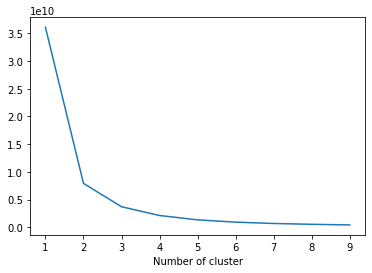

In [47]:
sse={}
df_cluster = df_data[['TotalCharges']]
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(df_cluster)
    df_cluster["clusters"] = kmeans.labels_
    sse[k] = kmeans.inertia_ 
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.show()

In [48]:
kmeans = KMeans(n_clusters=3)
kmeans.fit(df_data[['TotalCharges']])
df_data['TotalChargeCluster'] = kmeans.predict(df_data[['TotalCharges']])

In [49]:
df_data = order_cluster('TotalChargeCluster', 'TotalCharges',df_data,True)

In [50]:
df_data.groupby('TotalChargeCluster').TotalCharges.describe()

count         mean          std     min        25%  \
TotalChargeCluster                                                        
0                   4134.0   678.203907   564.825533    18.8   160.2250   
1                   1608.0  3222.924067   805.254244  1940.8  2509.7750   
2                   1290.0  6255.823140  1019.137480  4729.3  5430.8375   

                         50%        75%      max  
TotalChargeCluster                                
0                    530.525  1128.8500  1939.35  
1                   3168.375  3919.6375  4720.00  
2                   6125.750  7014.3000  8684.80

In [51]:
df_data['TotalChargeCluster'] = df_data["TotalChargeCluster"].replace({0:'Low',1:'Mid',2:'High'})

In [52]:
df_plot = df_data.groupby('TotalChargeCluster').Churn.mean().reset_index()
plot_data = [
    go.Bar(
        x=df_plot['TotalChargeCluster'],
        y=df_plot['Churn'],
        width = [0.5, 0.5, 0.5],
        marker=dict(
        color=['green', 'blue', 'orange'])
    )
]

plot_layout = go.Layout(
        xaxis={"type": "category","categoryarray":['Low','Mid','High']},
        title='Total Charge Cluster vs Churn Rate',
        plot_bgcolor  = "rgb(243,243,243)",
        paper_bgcolor  = "rgb(243,243,243)",
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

In [53]:
df_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7031
Data columns (total 24 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   customerID            7032 non-null   object 
 1   gender                7032 non-null   object 
 2   SeniorCitizen         7032 non-null   int64  
 3   Partner               7032 non-null   object 
 4   Dependents            7032 non-null   object 
 5   tenure                7032 non-null   int64  
 6   PhoneService          7032 non-null   object 
 7   MultipleLines         7032 non-null   object 
 8   InternetService       7032 non-null   object 
 9   OnlineSecurity        7032 non-null   object 
 10  OnlineBackup          7032 non-null   object 
 11  DeviceProtection      7032 non-null   object 
 12  TechSupport           7032 non-null   object 
 13  StreamingTV           7032 non-null   object 
 14  StreamingMovies       7032 non-null   object 
 15  Contract             

# Feature engineering for Categorical Columns

**Label Encoder** converts categorical columns to numerical by simply assigning integers to distinct values. For instance, the column **gender** has two values: Female & Male. Label encoder will convert it to 1 and 0.

**get_dummies()** method creates new columns out of categorical ones by assigning 0 & 1s 

In [54]:
# Import Label Encoder
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
dummy_columns = [] # Array for multiple value columns

for column in df_data.columns:
    if df_data[column].dtype == object and column != 'customerID':
        if df_data[column].nunique() == 2:
            # Apply Label Encoder for binary ones
            df_data[column] = le.fit_transform(df_data[column]) 
        else:
            dummy_columns.append(column)

# Apply get dummies for selected columns
df_data = pd.get_dummies(data = df_data,columns = dummy_columns) 

In [55]:
df_data[['gender','Partner','TenureCluster_High','TenureCluster_Low','TenureCluster_Mid']].head()

gender  Partner  TenureCluster_High  TenureCluster_Low  TenureCluster_Mid
0       0        1                   0                  1                  0
1       0        0                   0                  1                  0
2       1        0                   0                  1                  0
3       1        0                   0                  1                  0
4       1        1                   0                  1                  0

# Logistic Regression

Predicting churn is a binary classification problem. Customers either churn or retain in a given period. Along with being a robust model, Logistic Regression provides interpretable outcomes too. As we did before, let’s sort out our steps to follow for building a Logistic Regression model:

1. Prepare the data (inputs for the model)
2. Fit the model and see the model summary

In [56]:
all_columns = []
for column in df_data.columns:
    column = column.replace(" ", "_").replace("(", "_").replace(")", "_").replace("-", "_")
    all_columns.append(column)

df_data.columns = all_columns

In [57]:
glm_columns = 'gender'

for column in df_data.columns:
    if column not in ['Churn','customerID','gender']:
        glm_columns = glm_columns + ' + ' + column

In [58]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
 

glm_model = smf.glm(formula='Churn ~ {}'.format(glm_columns), data=df_data, family=sm.families.Binomial())
res = glm_model.fit()
print(res.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  Churn   No. Observations:                 7032
Model:                            GLM   Df Residuals:                     7002
Model Family:                Binomial   Df Model:                           29
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2903.5
Date:                Fri, 12 Mar 2021   Deviance:                       5806.9
Time:                        15:11:18   Pearson chi2:                 7.57e+03
No. Iterations:                   100                                         
Covariance Type:            nonrobust                                         
                                              coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------

We have two important outcomes from this report. When you prepare a Churn Prediction model, you will face with the questions below:

1. Which characteristics make customers churn or retain?
2. What are the most critical ones? What should we focus on?

For the first question, you should look at the 4th column (P>|z|). If the absolute **p-value** is smaller than 0.05, it means, that feature affects Churn in a statistically significant way. Examples are:

* SeniorCitizen
* InternetService_DSL
* OnlineSecurity_NO

Then the second question. We want to reduce the Churn Rate, where we should start? The scientific version of this question is;

> Which feature will bring the best ROI if I increase/decrease it by one unit?

That question can be answered by looking at the **coef** column. Exponential **coef** gives us the expected change in Churn Rate if we change it by one unit. If we apply the code below, we will see the transformed version of all coefficients:

In [59]:
np.exp(res.params)

Intercept                                  1.277597
gender                                     0.977098
SeniorCitizen                              1.246524
Partner                                    1.000190
Dependents                                 0.876145
tenure                                     0.938908
PhoneService                               1.252200
PaperlessBilling                           1.414050
MonthlyCharges                             0.966223
TotalCharges                               1.000141
MultipleLines_No                           0.890439
MultipleLines_No_phone_service             1.020282
MultipleLines_Yes                          1.406272
InternetService_DSL                        0.545770
InternetService_Fiber_optic                2.854274
InternetService_No                         0.820142
OnlineSecurity_No                          1.384811
OnlineSecurity_No_internet_service         0.820142
OnlineSecurity_Yes                         1.124902
OnlineBackup

As an example, one unit change in Monthly Charge means ~3.4% (1-0.966=0.034) improvement in the odds for churning if we keep everything else constant.

# Binary Classification Model with XGBoost

In [60]:
# Create feature set and labels
X = df_data.drop(['Churn','customerID'],axis=1)
y = df_data.Churn

In [61]:
# Train and test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, random_state=56)

In [62]:
# Building the model
xgb_model = xgb.XGBClassifier(max_depth=5, learning_rate=0.08, objective= 'binary:logistic',n_jobs=-1).fit(X_train, y_train)

print('Accuracy of XGB classifier on training set: {:.2f}'
       .format(xgb_model.score(X_train, y_train)))
print('Accuracy of XGB classifier on test set: {:.2f}'
       .format(xgb_model.score(X_test[X_train.columns], y_test)))

Accuracy of XGB classifier on training set: 0.84
Accuracy of XGB classifier on test set: 0.82


In [63]:
y_pred = xgb_model.predict(X_test)

In [64]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.84      0.92      0.88       255
         1.0       0.73      0.55      0.62        97

    accuracy                           0.82       352
   macro avg       0.78      0.73      0.75       352
weighted avg       0.81      0.82      0.81       352



We can interpret the report above as if our model tells us, 100 customers will churn, 73 of it will churn (0.73 precision). Especially recall is the main problem here, and we can improve our model’s overall performance by:

* Adding more data (we have around 2k rows for this example)
* Adding more features
* More feature engineering
* Trying other models
* Hyper-parameter tuning

<AxesSubplot:>

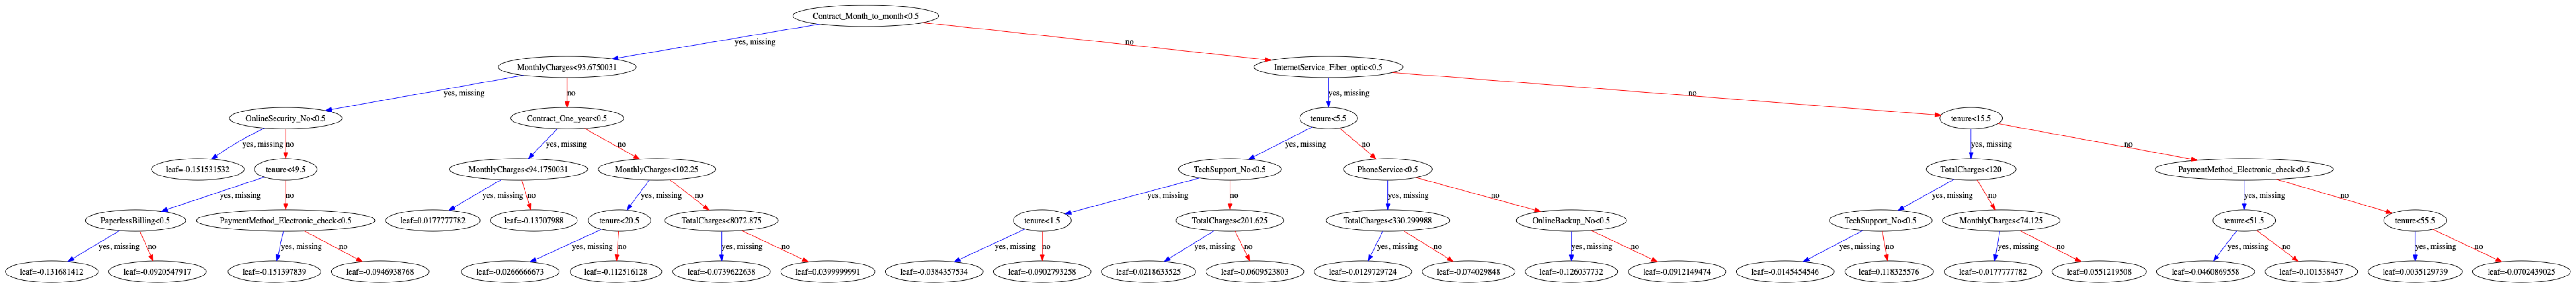

In [66]:
from xgboost import plot_tree

# Set up the parameters
fig, ax = plt.subplots(figsize=(100,100))
plot_tree(xgb_model, ax=ax)

In [67]:
1/(1+np.exp(-0.032))

0.5079993174032311

In [68]:
from xgboost import plot_importance

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

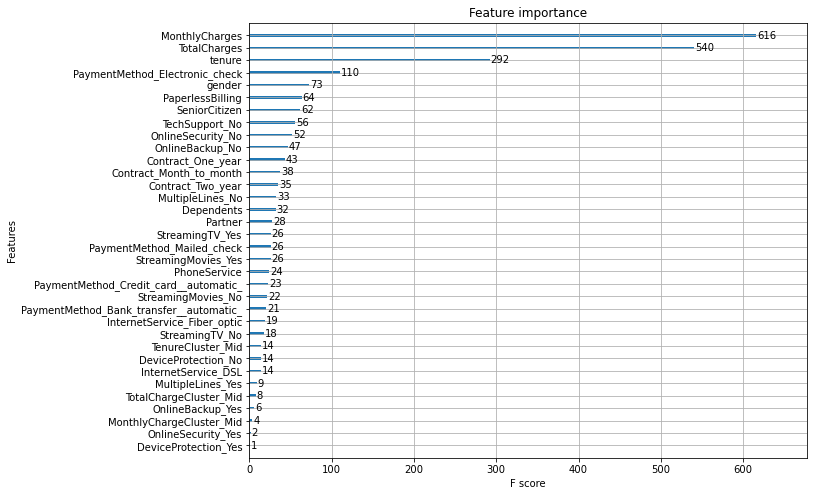

In [69]:
fig, ax = plt.subplots(figsize=(10,8))
plot_importance(xgb_model, ax=ax)

We can see that our model assigned more importance to **TotalCharges** and **MonthlyCharges** compared to others.

Finally, the best way to use this model is assigning Churn Probability for each customer, create segments, and build strategies on top of that. To get the churn probability from our model, utilize the code block below:

In [70]:
df_data['proba'] = xgb_model.predict_proba(df_data[X_train.columns])[:,1]

In [71]:
df_data[['customerID', 'proba']].head()

customerID     proba
0  7590-VHVEG  0.511120
1  6713-OKOMC  0.119306
2  7469-LKBCI  0.016499
3  8779-QRDMV  0.925943
4  1680-VDCWW  0.053974